# Predict Future Sales
## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import sklearn
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import tensorflow as tf
import keras
from itertools import product



## Load dataset

In [2]:
sales = pd.read_csv('Dataset/sales_train_v2.csv')
shops = pd.read_csv('Dataset/shops.csv')
items = pd.read_csv('Dataset/items.csv')
items_categories = pd.read_csv('Dataset/item_categories.csv')
sample_submission = pd.read_csv('Dataset/sample_submission.csv')
test_data = pd.read_csv('Dataset/test.csv')

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## Exploratory Data Analysis


## Popular shops based on item count in the last 33 months

Text(0.5, 1.0, 'Popular shops')

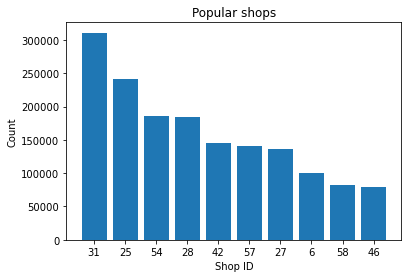

In [4]:
popular_shops = sales.groupby('shop_id')['item_cnt_day'].sum()
popular_shops = popular_shops.sort_values(ascending=False)[:10]
index = [str(i) for i in list(popular_shops.index)]
plt.bar(index,list(popular_shops.values))
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Popular shops")

- 31 sold more number of items in the last 33 months.
- 46 sold the fewest items in 33 months


## Popular items based on item count in the last 33 months

Text(0.5, 1.0, 'Popular items')

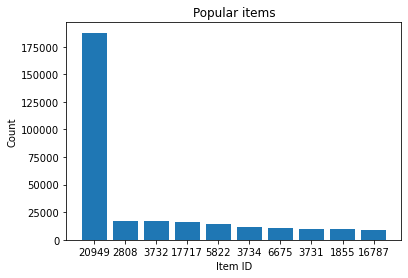

In [5]:
popular_items = sales.groupby('item_id')['item_cnt_day'].sum()
popular_items = popular_items.sort_values(ascending=False)[:10]
index = [str(i) for i in list(popular_items.index)]
plt.bar(index,list(popular_items.values))
plt.xlabel("Item ID")
plt.ylabel("Count")
plt.title("Popular items")

- 20949 is the item that was sold more number of items in the last 33 months.
- 16787  is the rarest selling item 

## Number of items per category


Text(0.5, 1.0, 'Number of items per category')

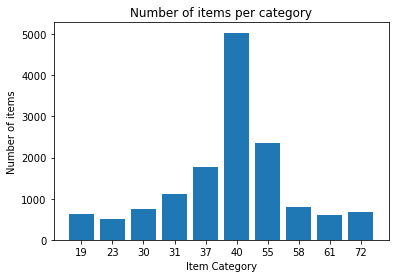

In [6]:
items_per_category = items.item_category_id.value_counts().iloc[:10]
items_per_category = items_per_category.sort_index(sort_remaining=True)
index = [str(i) for i in list(items_per_category.index)]
plt.bar(index,list(items_per_category.values))
plt.xlabel("Item Category")
plt.ylabel("Number of items")
plt.title("Number of items per category")

## Count of items sold in each month


In [7]:
item_cnt_month = sales.groupby('date_block_num')['item_cnt_day'].sum()


Text(0.5, 1.0, 'Number of items sold in each month')

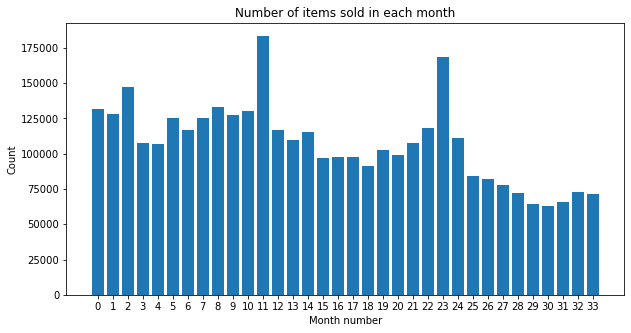

In [8]:
plt.figure(figsize=(10,5))
index = [str(i) for i in list(item_cnt_month.index)]
plt.bar(index,list(item_cnt_month.values))
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Number of items sold in each month")

- The number of items is the biggest in 11 month 

## Total price of items sold in each month


Text(0.5, 1.0, 'Total price of items sold in each month')

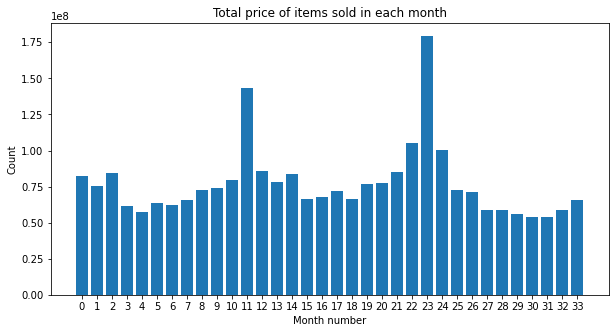

In [9]:
price_cnt_month = sales.groupby('date_block_num')['item_price'].sum()
plt.figure(figsize=(10,5))
index = [str(i) for i in list(price_cnt_month.index)]
plt.bar(index,list(price_cnt_month.values))
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Total price of items sold in each month")

#### Correlation between "Number of items sold" and "Total price of all items" in each month


In [10]:
print('Correlation is ',np.corrcoef(item_cnt_month.values, price_cnt_month.values)[0][1])


Correlation is  0.7346919085140743


## Preprocessing and Feature Engineering


#### Test data - Add date_block_num=34


In [11]:
test_block = sales.date_block_num.max() + 1
test_data['date_block_num'] = test_block
test_data = test_data.drop(columns=['ID'])
test_data.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


#### Create grid from all shops/items combinations from that month


In [12]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
unique_date_block_num = sales['date_block_num'].unique()
for i in unique_date_block_num:
    
    shops = sales[sales['date_block_num'] == i]['shop_id'].unique()
    items1 = sales[sales['date_block_num'] == i][ 'item_id'].unique()
    grid.append(np.array(list(product(*[shops, items1, [i]]))))

stacked = np.vstack(grid)
grid = pd.concat([pd.DataFrame(stacked, columns = index_cols), test_data])
grid.head()


,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


#### Create features by grouping shops, items and month


In [13]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols, as_index=False)['item_cnt_day'].sum().rename(columns={'item_cnt_day': 'target'})
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum().rename(columns={'item_cnt_day': 'target_shop'})
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum().rename(columns={'item_cnt_day': 'target_item'})
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)


del grid, gb 

all_data.head()


,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


#### Create features using previous months data - Different lags


In [14]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols))
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in shift_range:
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
del train_shift

In [15]:
all_data.head()


,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
0,59,22154,0,1.0,2017.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,2017.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,2017.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,2017.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Add "item category id" as a feature


In [16]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
# We will drop these at fitting stage
to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

# Category for each item
item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')



all_data.head()




,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,...,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


#### Split data - Train and Test


In [17]:
dates = all_data['date_block_num']

dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]
X_train = all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  test_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,...,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


#### Target range - Clip it to [0, 20]


In [18]:
target_range = [0, 20]
target_range

[0, 20]

# Modelling

## Linear Regression


In [19]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lr})
submission.to_csv('Predictions/submission_linear_regression.csv', index=False)
submission.head()


,ID,item_cnt_month
0,0,0.595136
1,1,0.101658
2,2,0.955156
3,3,0.234573
4,4,0.118508


### LightGBM

In [20]:
import pickle
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test).clip(*target_range)
pkl_filename = "Models/lgb_classifier.pkl"  
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lgb})
submission.to_csv('Predictions/submission_lgb.csv', index=False)

### Concatenate test predictions to get test meta -features

In [21]:
X_test_level2 = np.c_[pred_lr, pred_lgb]
X_test_level2

array([[0.59513646, 0.45643478],
       [0.10165797, 0.17876025],
       [0.95515631, 0.83559476],
       ...,
       [0.08131603, 0.0456353 ],
       [0.1054668 , 0.04369351],
       [0.09177211, 0.04369351]])

## Validation - Second level

### Train meta-features

In [22]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(dates_train_level2)]

### Time series data - Use 2nd level validation scheme accordingly

**KFold scheme in time series**

In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.
- Split the train data into chunks of duration T. Select first M chunks.
- Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.
- Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

In [23]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    print(cur_block_num)
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    X_train_cur = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test_cur =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train_cur = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_cur =  all_data.loc[dates == cur_block_num, 'target'].values
    
    lr.fit(X_train_cur.values, y_train_cur)
    pred_lr = lr.predict(X_test_cur.values)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = pred_lr.clip(*target_range)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_cur, label=y_train_cur), 100)
    pred_lgb = model.predict(X_test_cur)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = pred_lgb.clip(*target_range)

27
28
29
30
31
32
33


### Ensembling - Simple averaging

In [24]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = []
for alpha in alphas_to_try:
    mix = alpha*X_train_level2[:,0] + (1-alpha)*X_train_level2[:,1]
    r2_scores.append(r2_score(y_train_level2, mix))

r2_scores = np.array(r2_scores)

# YOUR CODE GOES HERE
best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.045000; Corresponding r2 score on train: 0.083548


In [25]:
pred_simple_averaging = best_alpha*X_test_level2[:,0] + (1-best_alpha)*X_test_level2[:,1]
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_simple_averaging})
submission.to_csv('Predictions/submission_simple_averaging.csv', index=False)

### Ensembling - Stacking

In [26]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression()

In [27]:
pred_stacking = lr.predict(X_test_level2).clip(*target_range)

In [28]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_stacking})
submission.to_csv('Predictions/submission_stacking.csv', index=False)
pred_stacking

array([0.64636206, 0.10313554, 1.26659477, ..., 0.        , 0.        ,
       0.        ])